## IMRT optimization demo

In this demo, we illustrate a few simple examples of plan optimization for radiation therapy. We start by importing the needed packages and define a helper plotting function:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from therapy_planner.interface import PlannerInterface
import numpy as np

# helper function for plotting maps
def plot_map(dose_map, name, ax, cmap, fontsize=14):
    m,n = dose_map.shape
    im = ax.imshow(dose_map, cmap=cmap)
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("dose", rotation=-90, va="bottom", size=14)
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    ax.set_xticks([])
    ax.set_yticks([])
    textcolors=["black", "white"]
    threshold = im.norm(dose_map.max())/2.
    for i in range(m):
        for j in range(n):
            text = ax.text(j,i,np.round(dose_map[i,j],2),size=fontsize,
                           ha="center", va="center",color=textcolors[(im.norm(dose_map[i,j])>threshold).astype(np.int)])
    ax.text(0.5,-0.1,"{} map".format(name),
            horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes, size=14)

The user begins by creating a plan through the `PlannerInterface` Class by supplying an input file of the target, maximum, and minimum doses to be delivered to a region. Here we get the target, max, and min maps, and visualize the specified doses.

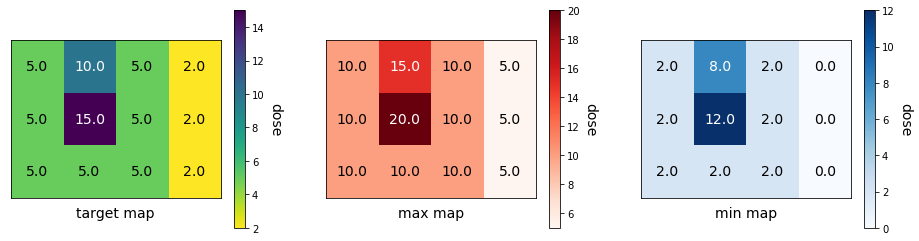

In [2]:
m = 3
n = 4
plan = PlannerInterface("dose_3x4.map")
maps = plan.get_maps()

fig, axes = plt.subplots(1,3,figsize=(16,4))
cmaps = ["viridis_r", "Reds", "Blues"]
for (key, val), ax, cmap in zip(maps.items(),axes.flat,cmaps):
    plot_map(val, key, ax, cmap)
plt.show()

Next we run the `optimize` method of the `PlannerInterface` Class outlined in the `interface` module. The required input is the allowed exposure time, which is used to optimize two quantities:
1. horizontal and vertical beam intensities
2. sequence of collimator apertures for each beam, adjusted over the course of exposure, to tune the amount of radiation delivered to specific regions.

For demonstration, this method now looks only at the target map and does a least squares minimization. We also add a penalty term to the optimizer which works similarly to a regularizer; in this case, the penalty term will be a logistic function with smoothness parameter equal to 1 (default), which penalizes any parameters tending below zero.

The `optimize` function returns the optimized dose map and the horizontal and vertical beam objects, whose attributes include the beam intensity, intermediate "beamlets" used to solve for the collimator apertures, and the sequence of left and right collimator positions. In addition, the `print_summary()` method prints a summary of several useful aspects of the plan.

Minimum found.


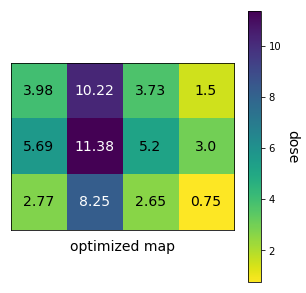

Horizontal beam intensity: 0.93 mW/cm^2
Horizontal beam exposure time: 4 sec.
Vertical beam intensity: 2.12 mW/cm^2
Vertical beam exposure time: 4 sec.
Total accumulated dose: 59.12 Gy
Average dose per unit area: 4.93 Gy/cm^2



In [3]:
dose_map, horiz_beam, vert_beam = plan.optimize(exposure_time=4)
fig, ax = plt.subplots(1,1,figsize=(5,5))
plot_map(dose_map, "optimized", ax, "viridis_r")
plt.show()

plan.print_summary()

Below we visualize the adjustment of the collimator apertures over the course of the exposure time to achieve the desired dose. For example, we can observe that the second slot of the vertical beam collimator remains exposed to radiation over the full exposure time, and is in fact the column which receives the highest dose.

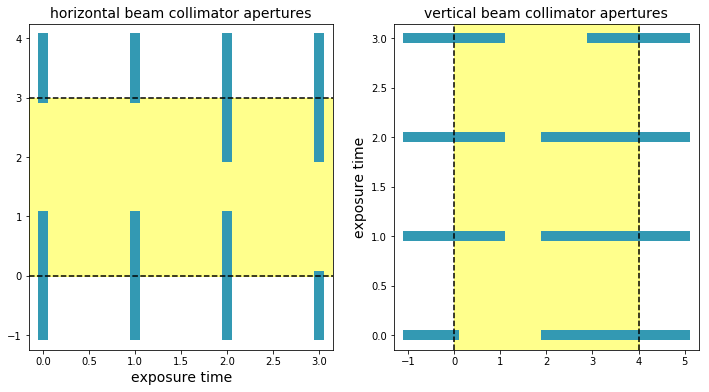

In [4]:
def plot_apertures(m,n,horiz_collimator,vert_collimator):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
    for t,(left, right) in enumerate(zip(horiz_collimator["left"],horiz_collimator["right"])):
        ax1.plot([t,t],[m+1,m-left],lw=10,color=[0.2,0.6,0.7])
        ax1.plot([t,t],[m-right,-1],lw=10,color=[0.2,0.6,0.7])
    ax1.axhline(0,linestyle='dashed',color='k')
    ax1.axhline(m,linestyle='dashed',color='k')
    ax1.axhspan(0,m,alpha=0.5,color=[1.0,1.0,0.1])
    ax1.set_xlabel('exposure time',size=14)
    ax1.set_title('horizontal beam collimator apertures',size=14)
    for t,(left, right) in enumerate(zip(vert_collimator["left"],vert_collimator["right"])):
        ax2.plot([-1,left],[t,t],lw=10,color=[0.2,0.6,0.7])
        ax2.plot([right,n+1],[t,t],lw=10,color=[0.2,0.6,0.7])
    ax2.axvline(0,linestyle='dashed',color='k')
    ax2.axvline(n,linestyle='dashed',color='k')
    ax2.axvspan(0,n,alpha=0.5,color=[1.0,1.0,0.1])
    ax2.set_ylabel('exposure time',size=14)
    ax2.set_title('vertical beam collimator apertures',size=14)
    plt.show()
    
plot_apertures(m,n,horiz_beam.collimator,vert_beam.collimator)

We can also observe the effect of increasing the exposure time. A longer exposure time permits a higher resolution of the delivered dose by reducing the beam intensity and increasing the number of increments for the collimators to be adjusted.

Minimum found.


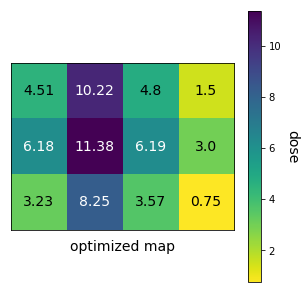

Horizontal beam intensity: 0.23 mW/cm^2
Horizontal beam exposure time: 16 sec.
Vertical beam intensity: 0.53 mW/cm^2
Vertical beam exposure time: 16 sec.
Total accumulated dose: 63.59 Gy
Average dose per unit area: 5.30 Gy/cm^2



In [5]:
dose_map, horiz_beam, vert_beam = plan.optimize(exposure_time=16)
fig, ax = plt.subplots(1,1,figsize=(5,5))
plot_map(dose_map, "optimized", ax, "viridis_r")
plt.show()

plan.print_summary()

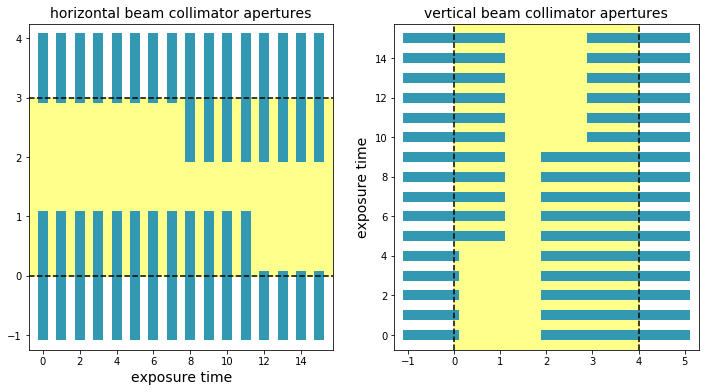

In [6]:
plot_apertures(m,n,horiz_beam.collimator,vert_beam.collimator)

Now we test a larger map:

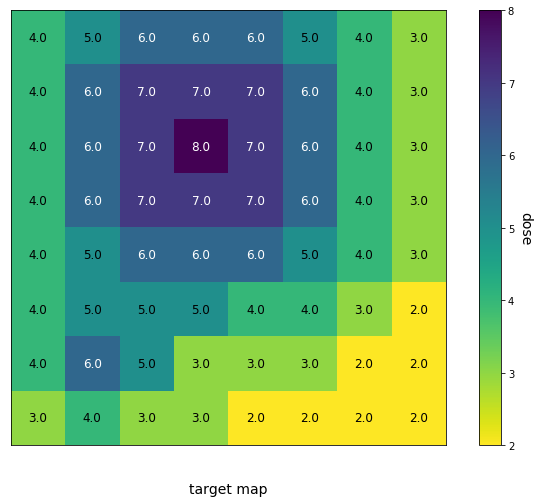

In [7]:
m = 8
n = 8
plan = PlannerInterface("dose_8x8.map")
maps = plan.get_maps()

fig, ax = plt.subplots(1,1,figsize=(12,8))
plot_map(maps['target'], 'target', ax, 'viridis_r', fontsize=12)
plt.show()

In [8]:
dose_map, horiz_beam, vert_beam = plan.optimize(exposure_time=20)

Minimum found.


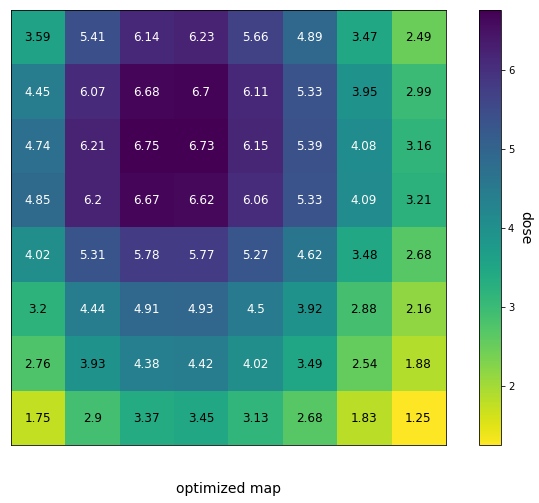

Horizontal beam intensity: 0.19 mW/cm^2
Horizontal beam exposure time: 20 sec.
Vertical beam intensity: 0.22 mW/cm^2
Vertical beam exposure time: 20 sec.
Total accumulated dose: 282.08 Gy
Average dose per unit area: 4.41 Gy/cm^2



In [9]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
plot_map(dose_map, 'optimized', ax, 'viridis_r', fontsize=12)
plt.show()

plan.print_summary()

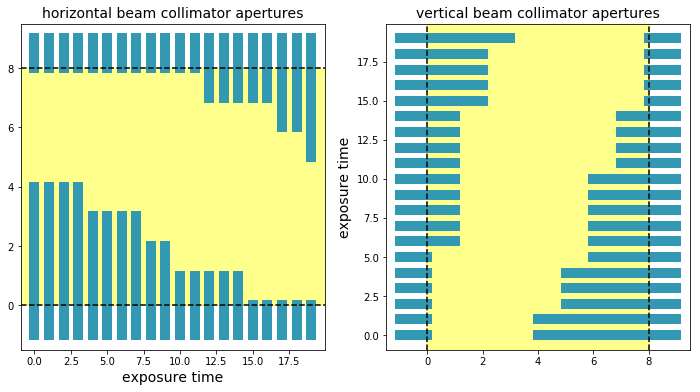

In [10]:
plot_apertures(m,n,horiz_beam.collimator,vert_beam.collimator)

We can also plot the difference between the optimized dose map and the target map to highlight over and underdosed regions.

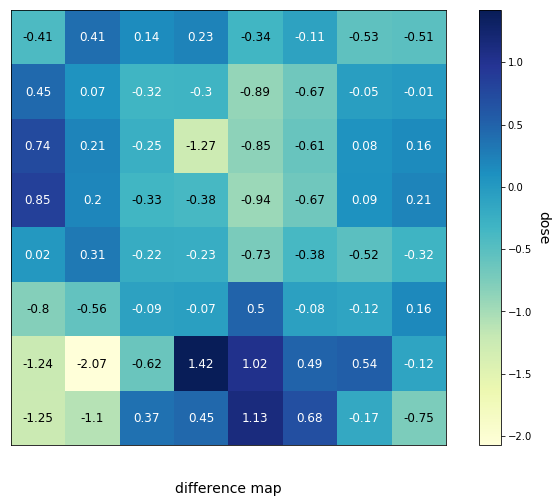

In [11]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
plot_map(dose_map-maps['target'], 'difference', ax, 'YlGnBu', fontsize=12)
plt.show()